In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.metrics import confusion_matrix
from tensorflow import keras

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, clone_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models


2024-09-26 12:06:54.139815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 12:06:54.139889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 12:06:54.142086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 12:06:54.153574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 12:06:55.357484: W tensorflow/compiler/tf2

In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices thru One-hot Encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


170498071/170498071 [==============================] - 3s 0us/step


In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

print(x_train.dtype)
print(x_train.ndim)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
float32
4


In [4]:
from keras.backend import clear_session
clear_session()

In [20]:
# DEFINE the Model

input_shape = (32, 32, 3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),        
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),    
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer """
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer        
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer """
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer
        layers.Dense(10, activation="softmax"),
    ]
)

In [21]:
# COMPILE the Model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [22]:
# DATA AUGMENTATION TO INCREASE THE TRAINING DATA BY APPLYING RANDOM TRANSFORMATION (like rotation, zooming)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Rotate images up to 15 degrees
    width_shift_range=0.1,   # Horizontally shift images by 10%
    height_shift_range=0.1,  # Vertically shift images by 10%
    horizontal_flip=True,    # Randomly flip images
)

# Fit the data generator on the training data
datagen.fit(x_train)



In [ ]:
# Using the data generator when training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(x_test, y_test))

#history = model.fit(x_train, y_train, batch_size=64, epochs=100)

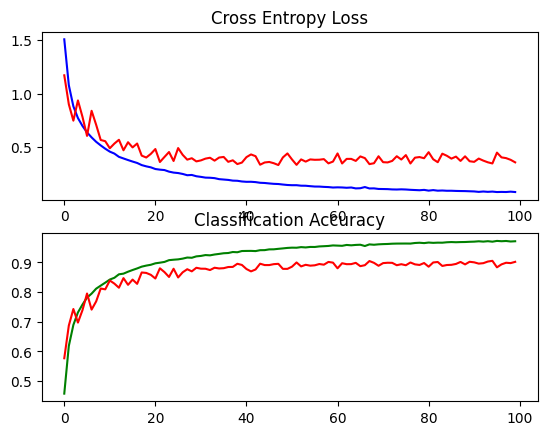

313/313 [==============================] - 1s 4ms/step - loss: 0.3579 - accuracy: 0.9022
Model Loss: 0.35794973373413086
Model Accuracy: 0.9021999835968018
313/313 [==============================] - 1s 3ms/step


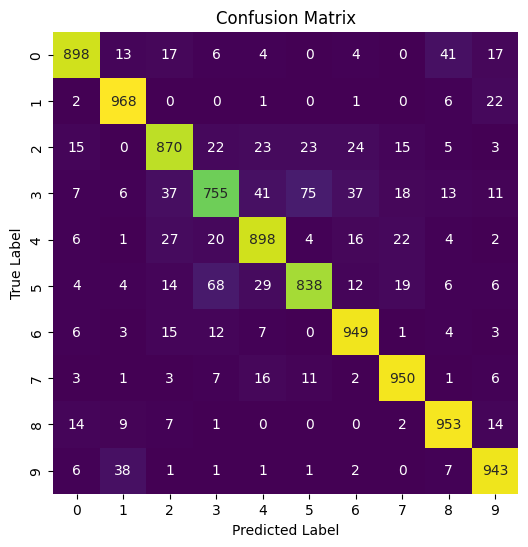

In [16]:

def evaluate_model(model, history):
    
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='val')

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='val')
    plt.show()

    # evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Model Loss:', test_loss)
    print('Model Accuracy:', test_acc)

    # make predictions
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    conf_mat = confusion_matrix(y_test_labels, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    
evaluate_model(model,history)

In [17]:
# Evaluate the model with test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3579 - accuracy: 0.9022


In [ ]:
# DISPLAY IMAGES TO SEE WHAT THE MODEL IS SEEING/PREDICTING

import numpy as np
import matplotlib.pyplot as plt

# y_test is the true labels and y_pred is the predicted labels
# Also assuing x_test contains the original images

# Get the index of images to display
num_images = 10  # Number of images to display
indices = np.random.choice(np.arange(len(y_test)), size=num_images, replace=False)

# Prepare the figure
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    plt.subplot(2, num_images // 2, i + 1)  # Create a subplot grid
    plt.imshow(x_test[idx])  # Display the image
    plt.axis('off')  # Turn off axis
    
    # Display true and predicted labels
    true_label = np.argmax(y_test[idx])  # Get the true label
    predicted_label = np.argmax(y_pred[idx])  # Get the predicted label
    plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)

plt.tight_layout()
plt.show()


# USING VGG16 to Evaluate the Accuracy 
 Step1: Exclude the final classification layer and keep the other layers
 Step2: Freeze all the VGG16 Layers
 Step3: Create new layer/model on top of VGG16 model
 Step4: Compile the model
 Step5: Train the model using CIFAR10 DS from above
 Step6: Evaluate the Model

In [4]:
# USING VGG16 to Evaluate the Accuracy 

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load VGG16 model pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 layers
for layer in vgg_model.layers:
    layer.trainable = False

# Create a new model on top of VGG16
model_vgg = models.Sequential([
    vgg_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),
        
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),     
    layers.Dropout(0.2),

    layers.Dense(10, activation='softmax')
])


# Compile the model
model_vgg.compile(loss='categorical_crossentropy',
                  optimizer='adam', #Adjust learning rate
                  metrics=['accuracy'])

model_vgg.summary()

2024-09-26 12:07:39.606501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 12:07:39.666742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 12:07:39.667109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13

In [5]:
import tensorflow as tf

# Define a function to resize images on the fly that includes Data augmentation function
def preprocess_image(image, label, augment=False):
    # Resize to 224x224
    image = tf.image.resize(image, (224, 224))  

    # Include Data augmentation steps below. After resizing and before picking the next batch
    if augment:
        # Apply random flipping
        image = tf.image.random_flip_left_right(image)
        # Apply random contrast adjustment
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        # Apply random rotation (e.g., 20 degrees)
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
                               
    return image, label


# Convert the training dataset to TensorFlow Dataset API and apply augmentation + preprocessing
# Resizing done in batches of 32 instead of whole DS, leading to memory crash, Prefetch loads the next set while the current batch is in progress.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, augment=True)).batch(128).prefetch(tf.data.AUTOTUNE)

# Convert the test dataset and apply only preprocessing (no augmentation)
# Resizing done in batches of 32 instead of whole DS, leading to memory crash, Prefetch loads the next set while the current batch is in progress.
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, augment=False)).batch(128).prefetch(tf.data.AUTOTUNE)

# Model training
history = model_vgg.fit(train_ds, epochs=50, validation_data=test_ds)


Epoch 1/50


2024-09-26 12:08:08.497899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-26 12:08:18.887409: I external/local_xla/xla/service/service.cc:168] XLA service 0x852dfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-26 12:08:18.887467: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-26 12:08:18.899630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727352499.068214      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 99s 214ms/step - loss: 2.0725 - accuracy: 0.3767 - val_loss: 1.8666 - val_accuracy: 0.4443
Epoch 2/50
391/391 [==============================] - 87s 223ms/step - loss: 1.6590 - accuracy: 0.4670 - val_loss: 1.3059 - val_accuracy: 0.5543
Epoch 3/50
391/391 [==============================] - 78s 198ms/step - loss: 1.5128 - accuracy: 0.5010 - val_loss: 1.1853 - val_accuracy: 0.5885
Epoch 4/50
391/391 [==============================] - 76s 195ms/step - loss: 1.4126 - accuracy: 0.5269 - val_loss: 1.1588 - val_accuracy: 0.5987
Epoch 5/50
391/391 [==============================] - 76s 193ms/step - loss: 1.3503 - accuracy: 0.5409 - val_loss: 1.0562 - val_accuracy: 0.6315
Epoch 6/50
391/391 [==============================] - 77s 198ms/step - loss: 1.2948 - accuracy: 0.5540 - val_loss: 1.0646 - val_accuracy: 0.6331
Epoch 7/50
391/391 [==============================] - 77s 196ms/step - loss: 1.2512 - accuracy: 0.5666 - val_loss: 1.0447 - val_accuracy: 0.6

In [6]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_vgg.evaluate(test_ds)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

79/79 [==============================] - 11s 142ms/step - loss: 0.9228 - accuracy: 0.6799
Test Loss: 0.922762393951416
Test Accuracy: 0.6798999905586243


79/79 [==============================] - 11s 137ms/step


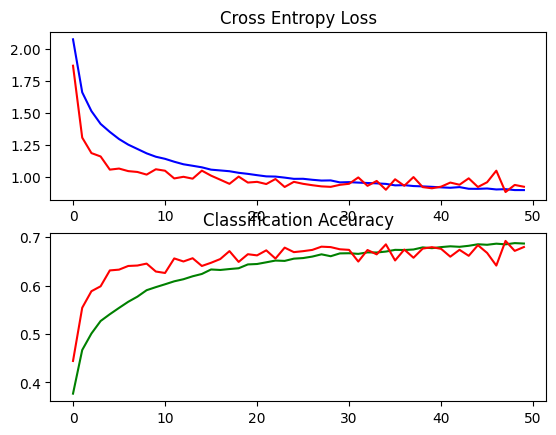

79/79 [==============================] - 11s 140ms/step - loss: 0.9228 - accuracy: 0.6799
Test Loss: 0.922762393951416
Test Accuracy: 0.6798999905586243


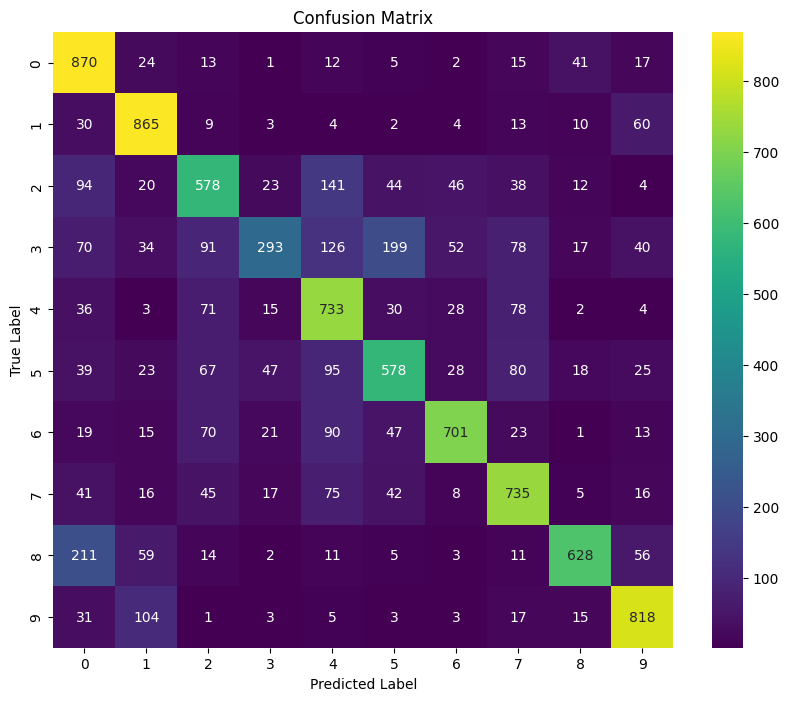

In [7]:
# Get the true labels and Make predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model_vgg.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions
y_true_classes = np.argmax(y_true, axis=1)

# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_vgg.evaluate(test_ds)
# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# TRANSFER LEARNING with VGG16
# Unfreeze the top few layers for fine-tuning
for layer in vgg_model.layers[-4:]:  # Fine-tune the last 4 layers
    layer.trainable = True

# Compile the model again with a lower learning rate
from tensorflow.keras.optimizers import Adam

model_vgg.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.00001),  # Lower learning rate for fine-tuning
                  metrics=['accuracy'])

# Continue training (fine-tuning the top layers)
history_fine_tune = model_vgg.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test))

# Evaluate the fine-tuned model
score_fine_tune = model_vgg.evaluate(x_test, y_test)
print(f'Fine-tuned VGG16 Test Loss: {score_fine_tune[0]}, Test Accuracy: {score_fine_tune[1]}')



In [ ]:
# FINE-TUNING of the VGG-16 Model Integration


# Unfreeze the top layers for fine-tuning
for layer in vgg_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True


In [ ]:
# COMPILE the Model

from tensorflow.keras.optimizers import Adam

# Compile with a lower learning rate
model_vgg.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
    metrics=['accuracy']
)


In [ ]:
# FIT the Model

history_fine_tune = model_vgg.fit(
    train_ds,                   # Your training dataset
    validation_data=test_ds,    # Your test dataset
    epochs=10,                  # Fine-tune for a few epochs, starting with 10 and then will try 20
    batch_size=128              # Adjust batch size as needed, starting with 128 will adjust to 64
)

In [ ]:
# EVALUATE the Fine-tuned Model

score_fine_tune = model_vgg.evaluate(test_ds)
print(f'Fine-tuned VGG16 Test Loss: {score_fine_tune[0]}, Test Accuracy: {score_fine_tune[1]}')

In [77]:
""" 
# Initialize the VGG16 model, pre-trained on ImageNet, without the top classification layer

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Extract features for the training and test sets
train_features = vgg16_model.predict(x_train)
test_features = vgg16_model.predict(x_test)

# Reshape the extracted features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Now the extracted features (train_features and test_features) can be used for further processing
print('Train features shape:', train_features.shape)
print('Test features shape:', test_features.shape) """


" \n# Initialize the VGG16 model, pre-trained on ImageNet, without the top classification layer\n\nvgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))\n\n# Extract features for the training and test sets\ntrain_features = vgg16_model.predict(x_train)\ntest_features = vgg16_model.predict(x_test)\n\n# Reshape the extracted features\ntrain_features = train_features.reshape(train_features.shape[0], -1)\ntest_features = test_features.reshape(test_features.shape[0], -1)\n\n# Now the extracted features (train_features and test_features) can be used for further processing\nprint('Train features shape:', train_features.shape)\nprint('Test features shape:', test_features.shape) "